In [1]:


import _init_paths
from PIL import Image
import numpy as np
import cv2
import random
import copy

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.trackers import *
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])
        
visualizer = Correspondence_Visualizer(mode='pca_corr', radius=6)


def build_model_(cfg, pretrained=None, torchvision_pretrain=True):
    
    model = mmcv.ConfigDict(type='VanillaTracker', backbone=cfg.model.backbone)
    if pretrained is not None:
        model.backbone.pretrained = pretrained
        model.backbone.torchvision_pretrain = torchvision_pretrain
    model = build_model(model, train_cfg=None, test_cfg=cfg.test_cfg)
        
    model_name = 'final'

    model = model.cuda()
    model.eval()
    return model

def main(x1, x2, model):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    visualizer.visualize([enc1.detach(), enc2.detach()], [frame1, frame2])
    # visualize_correspondence_quant(enc1, enc2, sample_idx, frame1, frame2, scale=32)


config = '/home/lr/project/vcl/configs/train/local/eval/res50_d4_eval.py'
cfg = mmcv.Config.fromfile(config)
model = build_model_(cfg,  pretrained='/home/lr/models/ssl/image_based/detco_200ep_AA.pth')

config = '/home/lr/project/vcl/configs/train/local/eval/res18_d4_eval.py'
cfg = mmcv.Config.fromfile(config)
# model2 = build_model_(cfg,  pretrained='/home/lr/mount/expdir/VCL/group_stsl/temp_res18_d4_l2_rec_concentration/epoch_160.pth', torchvision_pretrain=False)

model3 = build_model_(cfg,  pretrained='/home/lr/mount/expdir/VCL/group_stsl_former/mast_d4_l2_pyramid_dis_18/epoch_3200.pth', torchvision_pretrain=False)

model4 = build_model_(cfg,  pretrained='/home/lr/mount/expdir/VCL/group_motion_prediction/spa_res18_d4_l2_cmp_t0.0_m_Res18t_vae_learntp/epoch_160.pth', torchvision_pretrain=False)

# model5 = build_model_(cfg,  pretrained='/home/lr/mount/expdir/VCL/group_motion_prediction/spa_res18_d4_l2_cmp_t0.0_m_Res18t_exp_l1_ignore_boundary/epoch_160.pth', torchvision_pretrain=False)

# model6 = build_model_(cfg,  pretrained='/home/lr/mount/expdir/VCL/group_motion_prediction/spa_res18_d4_l2_cmp_t0.0_m_Res18t_exp_l1/epoch_160.pth', torchvision_pretrain=False)

# model7 = build_model_(cfg,  pretrained=None)

/home/lr/project/vcl/vcl/utils/visualize.py:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if radius is not -1:
2022-07-19 20:21:35,810 - vcl - INFO - Loading /home/lr/models/ssl/image_based/detco_200ep_AA.pth as torchvision


load checkpoint from local path: /home/lr/models/ssl/image_based/detco_200ep_AA.pth


2022-07-19 20:21:36,032 - vcl - INFO - Loading /home/lr/mount/expdir/VCL/group_stsl_former/mast_d4_l2_pyramid_dis_18/epoch_3200.pth not as torchvision
2022-07-19 20:21:36,033 - vcl - INFO - load checkpoint from local path: /home/lr/mount/expdir/VCL/group_stsl_former/mast_d4_l2_pyramid_dis_18/epoch_3200.pth
2022-07-19 20:21:36,210 - vcl - INFO - Loading /home/lr/mount/expdir/VCL/group_motion_prediction/spa_res18_d4_l2_cmp_t0.0_m_Res18t_vae_learntp/epoch_160.pth not as torchvision
2022-07-19 20:21:36,210 - vcl - INFO - load checkpoint from local path: /home/lr/mount/expdir/VCL/group_motion_prediction/spa_res18_d4_l2_cmp_t0.0_m_Res18t_vae_learntp/epoch_160.pth
2022-07-19 20:21:36,283 - vcl - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: motion_estimator.conv1.conv.weight, motion_estimator.conv1.bn.weight, motion_estimator.conv1.bn.bias, motion_estimator.conv1.bn.running_mean, motion_estimator.conv1.bn.running_var, motion_estimator.con

sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/79a5778027/00000.jpg


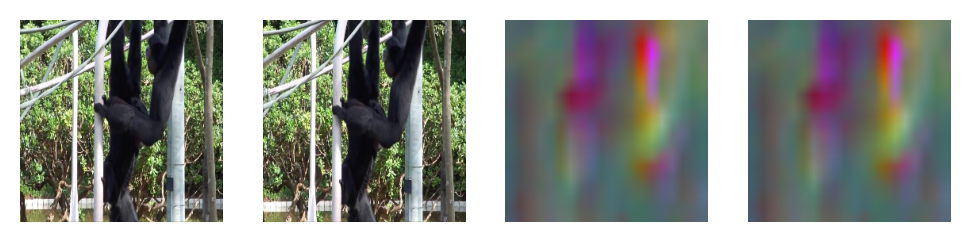

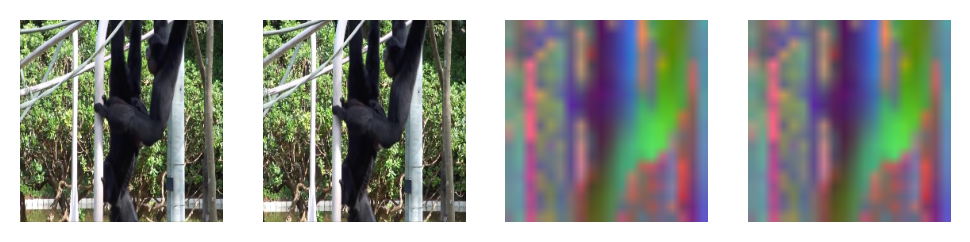

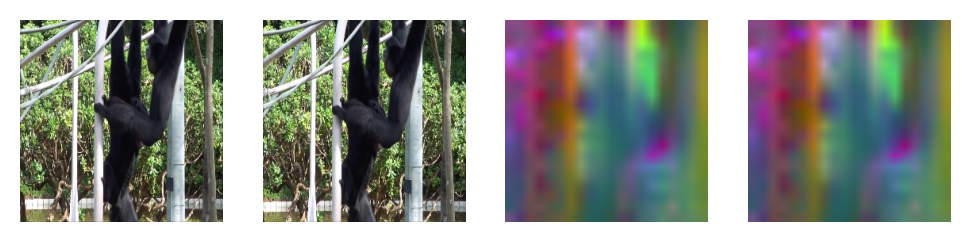

In [6]:
## sample frame
import os.path as osp
import glob


# sample_video_idx = 92
sample_video_idx = random.randint(0, 300)
sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))


frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]
video_name = sample['frames_path'][0].split('/')[-2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]

frame2 = cv2.imread(sample['frames_path'][min(frame_idx+1, len(sample['frames_path'])-1)])[:,:,::-1]
frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))

print('sample frames from {}'.format(sample['frames_path'][0]))

x1_rgb = preprocess_(frame1, mode='rgb')
x2_rgb = preprocess_(frame2, mode='rgb')

x1_lab = preprocess_(frame1, mode='lab')
x2_lab = preprocess_(frame2, mode='lab')

main(x1_rgb, x2_rgb, model)

# main(x1_lab, x2_lab, model2)


main(x1_lab, x2_lab, model3)


main(x1_lab, x2_lab, model4)


# main(x1_lab, x2_lab, model5)

# main(x1_lab, x2_lab, model6)
# main(x1_lab, x2_lab, model7)


